### Imports

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as ipw
from numpy.random import randn, rand

#matplotlib.rcParams['figure.facecolor'] = 'white'
#import vector_valued_with_RFF

#from vector_valued_with_RFF import capital_psi, alpha_approx

### Simulation parameters

In [247]:
w_0 = 0.1*2*np.pi
zeta = 1/np.sqrt(2)
# np.zeroes_like - return array of zeros w. same shape and type as a given array

time_start = 0
time_end = 100
time_step = 0.05 # this gives 2000 steps

time_series = np.arange(time_start, time_end, time_step)
number_of_timesteps = len(time_series)
init_condition = np.array([2, -2])

size_of_state = 2

### Van der Pol Oscillator

In [248]:
epsilon = 2

def model_van_der_pol(t, x):
    list = [x[1], epsilon * (1 - x[0]**2) * x[1] - x[0]]
    return np.array(list)

In [249]:
# Solve diff. equations with ODE
# similar to ODE45 in python: results = solve_ivp(obj_func, t_span, y0, t_eval = time_series)

# noise for a bit of challange
noise_sigma = 0.1

# init data containers
x = np.zeros((size_of_state, number_of_timesteps))
y = np.zeros((size_of_state, number_of_timesteps))

x[:, 0] = init_condition + np.multiply(noise_sigma, np.array(randn(size_of_state)))
y[:, 0] = model_van_der_pol(time_start, init_condition)

for i in range(0, number_of_timesteps - 1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x[:, i]

    # Sample dynamics at current time step
    y[:, i] = model_van_der_pol(time_series[i], start_state)
    
    # Propogate the state trajectory to next the time step using ODE-solver
    # solve_ivp is to replace the ode45 - solving odes
    partial_trajectory = solve_ivp(model_van_der_pol, timespan, start_state).y
    
    x[:, i+1] = partial_trajectory[:, -1] + np.multiply(noise_sigma, np.array(randn(size_of_state)))

### Free Harmonic Oscillator

In [250]:
def model_free_harmonic_oscillator(func, t, zeta, w_0):
    """Free Harmonic Oscillator ODE (Ordinary Differential equation)"""
    pass

### Generate data for vector field and streamlines

In [251]:
lower_bound_x1 = -4
upper_bound_x1 = 4
lower_bound_x2 = -5
upper_bound_x2 = 5

num_of_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

u = np.zeros(X1.shape)
v = np.zeros(X1.shape)
u_norm = np.zeros(X1.shape)
v_norm = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    # get velocities at each point
    Y_prime = model_van_der_pol(t, np.array([value, X2[i, j]]))
    u[i,j] = Y_prime[0]
    v[i,j] = Y_prime[1]

    # normalize vector length
    V_mod = np.sqrt(u[i,j]**2 + v[i,j]**2)
    u_norm[i,j] = u[i,j] / V_mod
    v_norm[i,j] = v[i,j] / V_mod

C:\Users\Heli\AppData\Local\Temp\ipykernel_16912\2403530062.py:30: RuntimeWarning: invalid value encountered in double_scalars
  u_norm[i,j] = u[i,j] / V_mod
C:\Users\Heli\AppData\Local\Temp\ipykernel_16912\2403530062.py:31: RuntimeWarning: invalid value encountered in double_scalars
  v_norm[i,j] = v[i,j] / V_mod


### Plot Van der Pol model

(-5.0, 5.0)

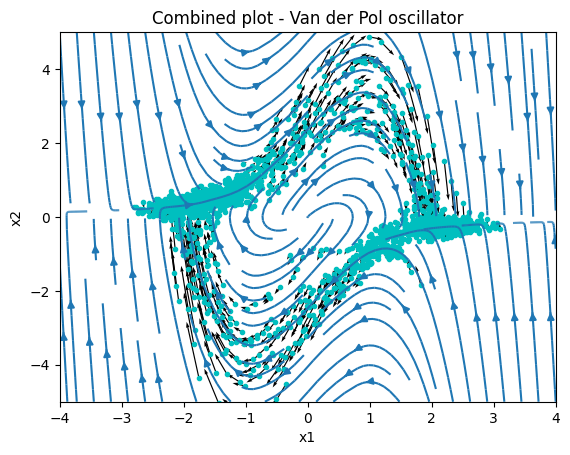

In [252]:
# Plot resulting trajectory in the data set and belonging streamlines
# Combine solution and vector field
plt.figure()
plt.style.use('default')
plt.title('Combined plot - Van der Pol oscillator')
plt.plot(x[0,:],x[1,:], '.', linewidth=1, color='c')

#ff.create_streamline(X1, X2, u, v)
plt.streamplot(X1, X2, u, v, density = 1)
plt.quiver(x[0,:], x[1,:], y[0,:], y[1,:])
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim([lower_bound_x1, upper_bound_x1])
plt.ylim([lower_bound_x2, upper_bound_x2])

### Regression problem

In [253]:
# Extract data series for y in the regression problem
data_series_start = np.argwhere(time_series == 15)[0,0] # to take the first element
data_series_end = np.argwhere(time_series == 22.6)[0,0]

# Training data
x_train = x[:, :]
y_train = y[:, :]
#x_train = x[:,  data_series_start:data_series_end]
#y_train = y[:,  data_series_start:data_series_end]

# Query only the length of the second dimension of x_train
num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]
num_of_points


2000

#### Plot resulting trajectory in the data set and belonging streamlines

(-5.0, 5.0)

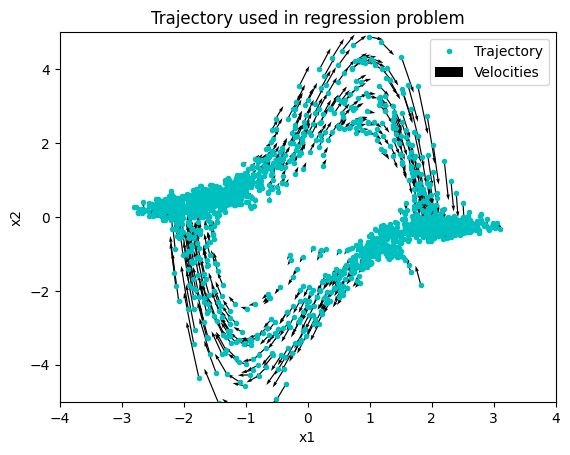

In [254]:
plt.style.use('default')
plt.figure()
plt.title('Trajectory used in regression problem')
plt.plot(x_train[0,:], x_train[1,:],'.', linewidth=2, color='c')
plt.quiver(x_train[0,:],x_train[1,:],y_train[0,:],y_train[1,:])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['Trajectory', 'Velocities'])
plt.xlim([lower_bound_x1, upper_bound_x1])
plt.ylim([lower_bound_x2, upper_bound_x2])

### Regression

In [255]:
# Random Fourier Features
sigma = 5
num_of_samples = 20

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi

### Regression

In [256]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))


def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

def alpha_approx(x_vector, y, dim, m, lam, n):
    phi_ = phi(x_vector, w, b, n, m, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.reshape(y, (-1,1))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha


In [257]:
# Get alphas (coefficient vectors)
lambda_ = 0.000001 # regularization parameter lamda
alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)

# Create callable function for learnt dynamics (straight from working note)
def learnt_model(t, x):
    func = capital_psi(x_train[:, i], w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func.T

### Simulation paramters

In [258]:
init_time = 0
end_time = 50
timespan = np.array([init_time, end_time])
init_condition = np.array([2, -2])

# Solve diff. equations using learnt model with solve_ivp
data_series = solve_ivp(learnt_model, timespan, init_condition).y

### Plot simulated trajectory and streamslices for learnt model


-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.4578301103792626
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
-0.06770812981352492
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.026461204125723725
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06063345990813218
0.06619546354130534
0.06619546354130534
0.06619546354130534
0.06619546354130534
0.0661954635413053

(-5.0, 5.0)

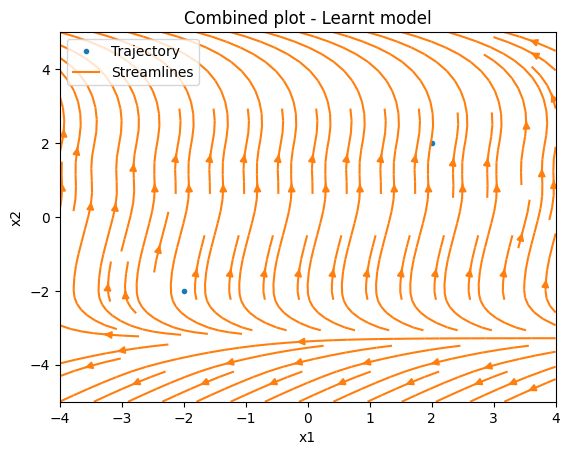

In [260]:
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i,j), value in np.ndenumerate(X1):

    # get velocities at each point
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[:,0]
    v_learnt[i,j] = Y_prime[:,1]

plt.figure()
plt.title('Combined plot - Learnt model')
plt.plot(data_series[:, 0], data_series[:, 1], '.', linewidth=1)
plt.streamplot(X1, X2, u_learnt, v_learnt)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['Trajectory', 'Streamlines'])
plt.xlim([lower_bound_x1, upper_bound_x1])
plt.ylim([lower_bound_x2, upper_bound_x2])